# FSRS4Anki v4.14.4 Simulator

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-spaced-repetition/fsrs4anki/blob/v4.14.4/fsrs4anki_simulator.ipynb)

↑ Click the above button to open the simulator on Google Colab.

> If you can't see the button and are located in the Chinese Mainland, please use a proxy or VPN.

In [1]:
# parameters for FSRS
w = [1.1008, 1.2746, 5.7619, 10.5114, 5.3148, 1.5796, 1.244, 0.003, 1.5741, 0.1741, 1.0137, 2.7279, 0.0114, 0.3071, 0.3981, 0.0, 1.9569]
requestRetention = 0.82  # recommended setting: 0.8 ~ 0.9

# parameters for Anki
graduatingInterval = 1
easyInterval = 4
easyBonus = 1.3
hardInterval = 1.2
intervalModifier = 1
newInterval = 0
minimumInterval = 1
leechThreshold = 8
leechSuspend = False

# common parameters
maximumInterval = 36500
new_cards_limits = 20
review_limits = 400
max_time_limts = 10000
learn_days = 300
deck_size = 20000

# get the true time from review logs
filename = "collection-2022-09-18@13-21-58.colpkg"

# smooth curves
moving_average_period = 14

# Set it to True if you don't want the optimizer to use the review logs from suspended cards.
filter_out_suspended_cards = False

# Red: 1, Orange: 2, Green: 3, Blue: 4, Pink: 5, Turquoise: 6, Purple: 7
# Set it to [1, 2] if you don't want the optimizer to use the review logs from cards with red or orange flag.
filter_out_flags = []

schedulers = ["anki", "fsrs"] # You can disable anki by removing it from this list

In [2]:
%pip install -q fsrs_optimizer==4.27.5
import pandas as pd
import numpy as np
import random

# for local development
# import os
# import sys
# sys.path.insert(0, os.path.abspath('../fsrs-optimizer/src/fsrs_optimizer/'))
import fsrs_optimizer as optimizer

optimizer = optimizer.Optimizer()
optimizer.anki_extract(filename, filter_out_suspended_cards, filter_out_flags)

New = 0
Learning = 1
Review = 2
Relearning = 3

df = pd.read_csv("./revlog.csv")
df.sort_values(by=["card_id", "review_time"], inplace=True, ignore_index=True)

new_card_revlog = df[
    (df["review_state"] == New) & (df["review_rating"].isin([1, 2, 3, 4]))
]
first_rating_prob = np.zeros(4)
first_rating_prob[new_card_revlog["review_rating"].value_counts().index - 1] = (
    new_card_revlog["review_rating"].value_counts()
    / new_card_revlog["review_rating"].count()
)
recall_card_revlog = df[
    (df["review_state"] == Review) & (df["review_rating"].isin([2, 3, 4]))
]
review_rating_prob = np.zeros(3)
review_rating_prob[recall_card_revlog["review_rating"].value_counts().index - 2] = (
    recall_card_revlog["review_rating"].value_counts()
    / recall_card_revlog["review_rating"].count()
)

df["review_state"] = df["review_state"].map(
    lambda x: x if x != New else Learning)

recall_costs = np.zeros(3)
recall_costs_df = recall_card_revlog.groupby(by="review_rating")[
    "review_duration"
].mean()
recall_costs[recall_costs_df.index - 2] = recall_costs_df / 1000

state_sequence = np.array(df["review_state"])
duration_sequence = np.array(df["review_duration"])
learn_cost = round(
    df[df["review_state"] == Learning]["review_duration"].sum()
    / len(df["card_id"].unique())
    / 1000,
    1,
)

state_block = dict()
state_count = dict()
state_duration = dict()
last_state = state_sequence[0]
state_block[last_state] = 1
state_count[last_state] = 1
state_duration[last_state] = duration_sequence[0]
for i, state in enumerate(state_sequence[1:]):
    state_count[state] = state_count.setdefault(state, 0) + 1
    state_duration[state] = state_duration.setdefault(
        state, 0) + duration_sequence[i]
    if state != last_state:
        state_block[state] = state_block.setdefault(state, 0) + 1
    last_state = state

recall_cost = round(state_duration[Review] / state_count[Review] / 1000, 1)

if Relearning in state_count and Relearning in state_block:
    forget_cost = round(
        state_duration[Relearning] /
        state_block[Relearning] / 1000 + recall_cost,
        1,
    )

print(f"average time for failed reviews: {forget_cost}s")
print(f"average time for recalled reviews: {recall_cost}s")
print(
    "average time for `hard`, `good` and `easy` reviews: %.1fs, %.1fs, %.1fs"
    % tuple(recall_costs)
)
print(f"average time for learning a new card: {learn_cost}s")
print(
    "Ratio of `hard`, `good` and `easy` ratings for recalled reviews: %.2f, %.2f, %.2f"
    % tuple(review_rating_prob)
)
print(
    "Ratio of `again`, `hard`, `good` and `easy` ratings for new cards: %.2f, %.2f, %.2f, %.2f"
    % tuple(first_rating_prob)
)


def generate_rating(review_type):
    if review_type == "new":
        return np.random.choice([1, 2, 3, 4], p=first_rating_prob)
    elif review_type == "recall":
        return np.random.choice([2, 3, 4], p=review_rating_prob)

Note: you may need to restart the kernel to use updated packages.
Deck file extracted successfully!
revlog.csv saved.
average time for failed reviews: 33.7s
average time for recalled reviews: 10.6s
average time for `hard`, `good` and `easy` reviews: 14.5s, 10.3s, 6.9s
average time for learning a new card: 25.7s
Ratio of `hard`, `good` and `easy` ratings for recalled reviews: 0.08, 0.90, 0.02
Ratio of `again`, `hard`, `good` and `easy` ratings for new cards: 0.21, 0.02, 0.48, 0.28


  0%|          | 0/300 [00:00<?, ?it/s]

scheduler: anki
learned cards: 6000
time in minutes: 10731.6
remembered cards: 5639
time per remembered card: 1.9
leeches: 14


  0%|          | 0/300 [00:00<?, ?it/s]

scheduler: fsrs
learned cards: 6000
time in minutes: 8268.8
remembered cards: 5451
time per remembered card: 1.52
leeches: 22


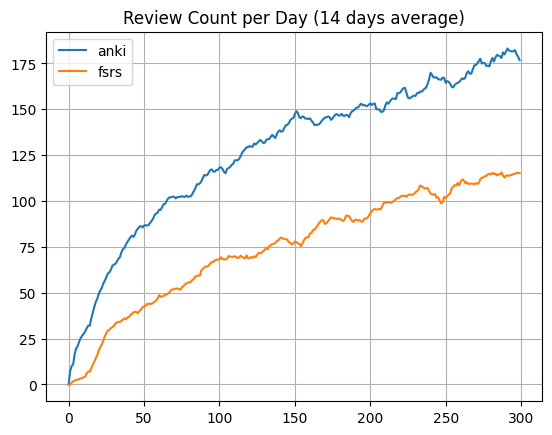

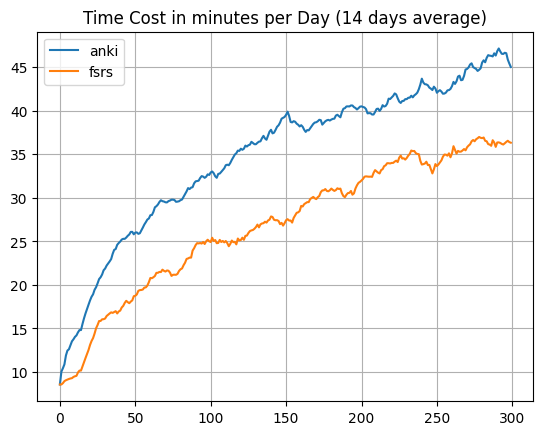

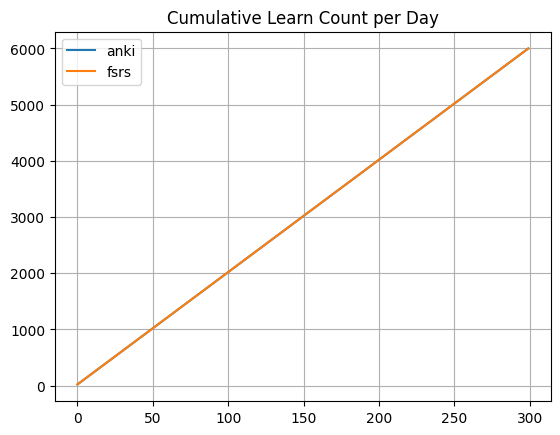

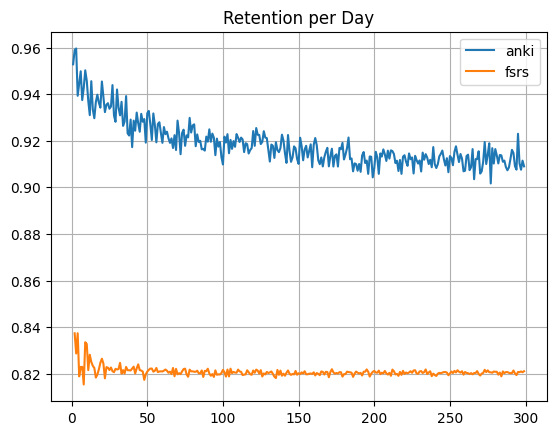

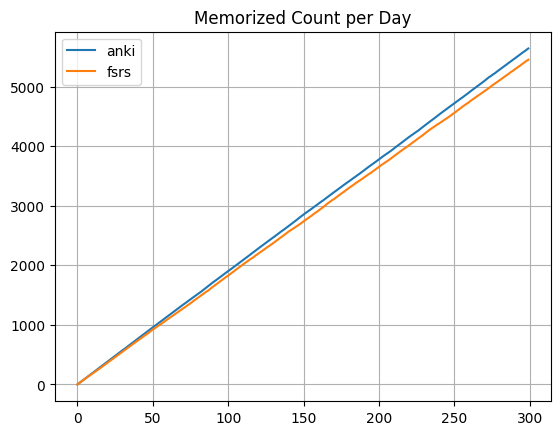

In [3]:
from fsrs_optimizer import next_interval, power_forgetting_curve, lineToTensor, FSRS
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


class Collection:
    def __init__(self):
        self.model = FSRS(w)
        self.model.eval()

    def states(self, t_history, r_history):
        with torch.no_grad():
            line_tensor = lineToTensor(
                list(zip([str(t_history)], [str(r_history)]))[0]
            ).unsqueeze(1)
            output_t = self.model(line_tensor)
            return output_t[-1][0]

    def next_states(self, states, t, r):
        with torch.no_grad():
            return self.model.step(torch.FloatTensor([[t, r]]), states.unsqueeze(0))[0]

    def init(self):
        t = 0
        r = generate_rating("new")
        p = round(first_rating_prob[r - 1], 2)
        new_states = self.states(t, r)
        return r, t, p, new_states


feature_list = [
    "difficulty",
    "stability",
    "retrievability",
    "delta_t",
    "reps",
    "lapses",
    "last_date",
    "due",
    "r_history",
    "t_history",
    "p_history",
    "states",
    "time",
    "factor",
]
field_map = {key: i for i, key in enumerate(feature_list)}


def fsrs4anki_scheduler(stability):
    def constrain_interval(stability):
        if stability > 0:
            return min(
                next_interval(stability, requestRetention),
                maximumInterval,
            )
        else:
            return 1

    interval = constrain_interval(stability)
    return interval


def anki_scheduler(interval, real_interval, factor, rating):
    if factor is None:
        return (graduatingInterval, 2.5) if rating != 4 else (easyInterval, 2.5)
    delay = real_interval - interval
    again_interval = min(
        max(round(interval * newInterval * intervalModifier + 0.01), minimumInterval),
        maximumInterval,
    )
    hard_interval = min(
        max(
            round(interval * hardInterval * intervalModifier + 0.01),
            interval + 1,
            minimumInterval,
        ),
        maximumInterval,
    )
    good_interval = min(
        max(
            round((interval + delay / 2) * factor * intervalModifier + 0.01),
            hard_interval + 1,
            minimumInterval,
        ),
        maximumInterval,
    )
    easy_interval = min(
        max(
            round(real_interval * factor * intervalModifier * easyBonus + 0.01),
            good_interval + 1,
            minimumInterval,
        ),
        maximumInterval,
    )
    if rating == 1:
        return again_interval, max(factor - 0.2, 1.3)
    if rating == 2:
        return hard_interval, max(factor - 0.15, 1.3)
    if rating == 3:
        return good_interval, max(factor, 1.3)
    if rating == 4:
        return easy_interval, max(factor + 0.15, 1.3)
    return maximumInterval, factor


def scheduler(scheduler_name, fsrs_inputs, anki_inputs):
    if scheduler_name == "anki":
        return anki_scheduler(*anki_inputs)
    elif scheduler_name == "fsrs":
        return fsrs4anki_scheduler(fsrs_inputs), 2.5
    return None


for scheduler_name in schedulers:
    new_card_per_day = np.array([0] * learn_days)
    new_card_per_day_average_per_period = np.array([0.0] * learn_days)
    review_card_per_day = np.array([0.0] * learn_days)
    review_card_per_day_average_per_period = np.array([0.0] * learn_days)
    time_per_day = np.array([0.0] * learn_days)
    time_per_day_average_per_period = np.array([0.0] * learn_days)
    learned_per_day = np.array([0.0] * learn_days)
    retention_per_day = np.array([0.0] * learn_days)
    expected_memorization_per_day = np.array([0.0] * learn_days)

    card = pd.DataFrame(
        np.zeros((deck_size, len(feature_list))),
        index=range(deck_size),
        columns=feature_list,
    )
    card["states"] = card["states"].astype(object)

    card["r_history"] = card["r_history"].astype(str)
    card["t_history"] = card["t_history"].astype(str)
    card["p_history"] = card["p_history"].astype(str)
    card["reps"] = 0
    card["lapses"] = 0
    card["due"] = learn_days

    student = Collection()
    random.seed(2022)
    for day in tqdm(range(learn_days)):
        reviewed = 0
        learned = 0
        review_time_today = 0
        learn_time_today = 0

        card["delta_t"] = day - card["last_date"]
        card["retrievability"] = power_forgetting_curve(card["delta_t"], card["stability"])
        need_review = (
            card[card["due"] <= day]
            if leechSuspend == False
            else card[(card["due"] <= day) & (card["lapses"] < leechThreshold)]
        )
        retention_per_day[day] = need_review["retrievability"].mean()
        for idx in need_review.index:
            if (
                reviewed >= review_limits
                or review_time_today + learn_time_today >= max_time_limts
            ):
                break

            reviewed += 1
            last_date = card.iat[idx, field_map["last_date"]]
            due = card.iat[idx, field_map["due"]]
            factor = card.iat[idx, field_map["factor"]]
            card.iat[idx, field_map["last_date"]] = day
            ivl = card.iat[idx, field_map["delta_t"]]
            card.iat[idx, field_map["t_history"]] += f",{ivl}"

            stability = card.iat[idx, field_map["stability"]]
            retrievability = card.iat[idx, field_map["retrievability"]]
            card.iat[idx, field_map["p_history"]] += f",{retrievability:.2f}"
            reps = card.iat[idx, field_map["reps"]]
            lapses = card.iat[idx, field_map["lapses"]]
            states = card.iat[idx, field_map["states"]]

            if random.random() < retrievability:
                rating = generate_rating("recall")
                recall_time = recall_costs[rating - 2]
                review_time_today += recall_time
                card.iat[idx, field_map["r_history"]] += f",{rating}"
                new_states = student.next_states(states, ivl, rating)
                new_stability = float(new_states[0])
                new_difficulty = float(new_states[1])
                card.iat[idx, field_map["stability"]] = new_stability
                card.iat[idx, field_map["difficulty"]] = new_difficulty
                card.iat[idx, field_map["states"]] = new_states
                card.iat[idx, field_map["reps"]] = reps + 1
                card.iat[idx, field_map["time"]] += recall_time

                delta_t, factor = scheduler(
                    scheduler_name,
                    new_stability,
                    (due - last_date, ivl, factor, rating),
                )
                card.iat[idx, field_map["factor"]] = factor
                card.iat[idx, field_map["due"]] = day + delta_t

            else:
                review_time_today += forget_cost

                rating = 1
                card.iat[idx, field_map["r_history"]] += f",{rating}"

                new_states = student.next_states(states, ivl, 1)
                new_stability = float(new_states[0])
                new_difficulty = float(new_states[1])

                card.iat[idx, field_map["stability"]] = new_stability
                card.iat[idx, field_map["difficulty"]] = new_difficulty
                card.iat[idx, field_map["states"]] = new_states

                reps = 0
                lapses = lapses + 1

                card.iat[idx, field_map["reps"]] = reps
                card.iat[idx, field_map["lapses"]] = lapses

                delta_t, factor = scheduler(
                    scheduler_name,
                    new_stability,
                    (due - last_date, ivl, factor, rating),
                )
                card.iat[idx, field_map["due"]] = day + delta_t
                card.iat[idx, field_map["factor"]] = factor
                card.iat[idx, field_map["time"]] += forget_cost

        need_learn = card[card["stability"] == 0]

        for idx in need_learn.index:
            if (
                learned >= new_cards_limits
                or review_time_today + learn_time_today >= max_time_limts
            ):
                break
            learned += 1
            learn_time_today += learn_cost
            card.iat[idx, field_map["last_date"]] = day

            card.iat[idx, field_map["reps"]] = 1
            card.iat[idx, field_map["lapses"]] = 0

            r, t, p, new_states = student.init()
            new_stability = float(new_states[0])
            new_difficulty = float(new_states[1])

            card.iat[idx, field_map["r_history"]] = str(r)
            card.iat[idx, field_map["t_history"]] = str(t)
            card.iat[idx, field_map["p_history"]] = str(p)
            card.iat[idx, field_map["stability"]] = new_stability
            card.iat[idx, field_map["difficulty"]] = new_difficulty
            card.iat[idx, field_map["states"]] = new_states

            delta_t, factor = scheduler(
                scheduler_name, new_stability, (None, None, None, r)
            )
            card.iat[idx, field_map["due"]] = day + delta_t
            card.iat[idx, field_map["time"]] = learn_cost
            card.iat[idx, field_map["factor"]] = factor

        new_card_per_day[day] = learned
        review_card_per_day[day] = reviewed
        learned_per_day[day] = learned_per_day[day - 1] + learned
        time_per_day[day] = review_time_today + learn_time_today
        expected_memorization_per_day[day] = sum(
            card[card["retrievability"] > 0]["retrievability"]
        )

        if day >= moving_average_period:
            new_card_per_day_average_per_period[day] = np.true_divide(
                new_card_per_day[day - moving_average_period: day].sum(),
                moving_average_period,
            )
            review_card_per_day_average_per_period[day] = np.true_divide(
                review_card_per_day[day - moving_average_period: day].sum(),
                moving_average_period,
            )
            time_per_day_average_per_period[day] = np.true_divide(
                time_per_day[day - moving_average_period: day].sum(),
                moving_average_period,
            )
        else:
            new_card_per_day_average_per_period[day] = np.true_divide(
                new_card_per_day[: day + 1].sum(), day + 1
            )
            review_card_per_day_average_per_period[day] = np.true_divide(
                review_card_per_day[: day + 1].sum(), day + 1
            )
            time_per_day_average_per_period[day] = np.true_divide(
                time_per_day[: day + 1].sum(), day + 1
            )

    total_learned = sum(new_card_per_day)
    total_time = sum(time_per_day)
    total_remembered = int(card["retrievability"].sum())
    total_leeches = len(card[card["lapses"] >= leechThreshold])

    plt.figure(1)
    plt.plot(review_card_per_day_average_per_period, label=f"{scheduler_name}")
    plt.figure(2)
    plt.plot(time_per_day_average_per_period / 60, label=f"{scheduler_name}")
    plt.figure(3)
    plt.plot(learned_per_day, label=f"{scheduler_name}")
    plt.figure(4)
    plt.plot(retention_per_day, label=f"{scheduler_name}")
    plt.figure(5)
    plt.plot(expected_memorization_per_day, label=f"{scheduler_name}")

    print("scheduler:", scheduler_name)
    print("learned cards:", total_learned)
    print("time in minutes:", round(total_time / 60, 1))
    print("remembered cards:", total_remembered)
    print("time per remembered card:", round(
        total_time / 60 / total_remembered, 2))
    print("leeches:", total_leeches)

    save = card[card["retrievability"] > 0].copy()
    save["stability"] = round(save["stability"], 2)
    save["retrievability"] = round(save["retrievability"], 2)
    save["difficulty"] = round(save["difficulty"], 2)
    save["factor"] = round(save["factor"], 2)
    save["time"] = round(save["time"], 2)

    save.to_csv(f"./simulator-{scheduler_name}.tsv", index=False, sep="\t")

plt.figure(1)
plt.title(f"Review Count per Day ({moving_average_period} days average)")
plt.legend()
plt.grid(True)
plt.figure(2)
plt.title(f"Time Cost in minutes per Day ({moving_average_period} days average)")
plt.legend()
plt.grid(True)
plt.figure(3)
plt.title(f"Cumulative Learn Count per Day")
plt.legend()
plt.grid(True)
plt.figure(4)
plt.title("Retention per Day")
plt.legend()
plt.grid(True)
plt.figure(5)
plt.title(f"Memorized Count per Day")
plt.legend()
plt.grid(True)
plt.show()
plt.close("all")